In [35]:
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.qualitymetrics as sqm
import spikeinterface.widgets as sw

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import glob

%matplotlib inline

#######################################################################
animal_ID = '98'
session_ID = '2024-04-15T12-20-01'

base_folder = r"W:\projects\FlexiVexi\behavioural_data"
session_folder = os.path.join(base_folder, animal_ID, session_ID)
#######################################################################


**Read in recording and spike sorting to create sorting analyser**

In [36]:
# Path to Kilosort3 output files within session folder
kilosort_folder = os.path.join(session_folder, 'kilosort3')

# Get output from spike sorting using Kilosort3, keeping only good units
sorting_KS = se.read_kilosort(folder_path=kilosort_folder,keep_good_only=False)
print(sorting_KS)

# Get path to Open-Ephys Record Node within session folder
matching_files = glob.glob(os.path.join(session_folder, '**', 'settings.xml'), recursive=True)
if matching_files:
    # Get the first matching file
    first_matching_file = matching_files[0]

    # Get the directory of the first matching file
    path_to_recording = os.path.dirname(first_matching_file)
else:
    print("No 'settings.xml' file found in the specified path.")
    
# Get recording from open ephys
recording = se.read_openephys(folder_path=path_to_recording, stream_name = 'Record Node 102#Neuropix-PXI-100.ProbeA')

# Create a sorting analyzer
sorting_analyzer = sc.create_sorting_analyzer(sorting_KS, recording)

# Compute sorting analyzer info
sorting_analyzer.compute("random_spikes")
sorting_analyzer.compute("waveforms")


KiloSortSortingExtractor: 112 units - 1 segments - 30.0kHz


estimate_sparsity:   0%|          | 0/3475 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/3475 [00:00<?, ?it/s]

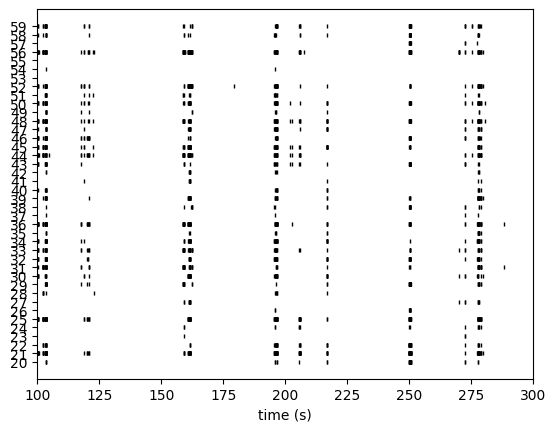

In [43]:

# Plots rasters of first 20 units
w_rs = sw.plot_rasters(sorting_analyzer, time_range=(100, 300), unit_ids=list(range(20,60)))

**Get recording metadata**

Sampling frequency: 30000.0
Number of channels: 384
Number of segments: 1
Probe - 384ch - 4shanks


(<matplotlib.collections.PolyCollection at 0x204a3b099a0>,
 <matplotlib.collections.PolyCollection at 0x20495a5fd40>)

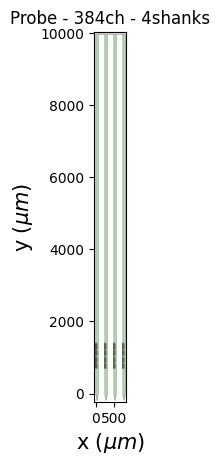

In [44]:
# Get basic meta-data from recording
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print("Sampling frequency:", fs)
print("Number of channels:", num_chan)
print("Number of segments:", num_seg)

probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

plot_probe(probe)

**Compute PCA and non-PCA metrics together**

In [46]:
sorting_analyzer.compute("templates")
sorting_analyzer.compute("noise_levels")
all_pcs = sorting_analyzer.compute("principal_components")

all_pcs = sorting_analyzer.get_extension('principal_components').get_data()
sorting_analyzer.get_extension('templates').get_data()

# depends on "waveforms", "templates", "noise_levels", and "pca" (if computing pca metrics)
qm_11 = sqm.compute_quality_metrics(sorting_analyzer, load_if_exists=None) 

# Save quality metrics to a .csv file
output_folder = os.path.join(session_folder, 'spikeinterface')
filename = 'quality_metrics_'+session_ID+'.csv'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
qm_11.to_csv(os.path.join(output_folder, filename))

Fitting PCA:   0%|          | 0/112 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/112 [00:00<?, ?it/s]

C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:880: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:724: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
C:\Users\megan\Documents\GitHub\spikeinterface\src\spikeinterface\qualitymetrics\misc_metrics.py:1457: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(


calculate_pc_metrics:   0%|          | 0/112 [00:00<?, ?it/s]

In [26]:
#sorting_analyzer.get_extension('principal_components').get_data()
dir(sqm.pca_metrics)
help(sqm.pca_metrics.nearest_neighbors_isolation)
#[isolation_distance, l_ratio] = sqm.isolation_distance(all_pcs=all_pcs, all_labels=all_labels, this_unit_id=0)
all_pcs = sorting_analyzer.compute("principal_components")

[isolation_distance, l_ratio] = sqm.pca_metrics.nearest_neighbors_isolation(all_pcs=all_pcs)


Help on function nearest_neighbors_isolation in module spikeinterface.qualitymetrics.pca_metrics:

nearest_neighbors_isolation(sorting_analyzer, this_unit_id: 'int | str', n_spikes_all_units: 'dict' = None, fr_all_units: 'dict' = None, max_spikes: 'int' = 1000, min_spikes: 'int' = 10, min_fr: 'float' = 0.0, n_neighbors: 'int' = 5, n_components: 'int' = 10, radius_um: 'float' = 100, peak_sign: 'str' = 'neg', min_spatial_overlap: 'float' = 0.5, seed=None)
    Calculates unit isolation based on NearestNeighbors search in PCA space.

    Parameters
    ----------
    sorting_analyzer: SortingAnalyzer
        A SortingAnalyzer object
    this_unit_id : int | str
        The ID for the unit to calculate these metrics for.
    n_spikes_all_units: dict, default: None
        Dictionary of the form ``{<unit_id>: <n_spikes>}`` for the waveform extractor.
        Recomputed if None.
    fr_all_units: dict, default: None
        Dictionary of the form ``{<unit_id>: <firing_rate>}`` for the wavefor

Fitting PCA:   0%|          | 0/97 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/97 [00:00<?, ?it/s]

TypeError: nearest_neighbors_isolation() got an unexpected keyword argument 'all_pcs'

**Analyse Units**

In [20]:
unit_locations = sorting_analyzer.compute(input="unit_locations", method="monopolar_triangulation")


**Export sorting analyser to Phy**

In [13]:
sexp.export_to_phy(sorting_analyzer, "phy", verbose=True)

NameError: name 'sexp' is not defined